#Лабораторная работа №1

Фавстова Александра 407

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from math import pi
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay
from lay import *

In [ ]:
ds = pd.read_csv('Mushrooms.csv')

In [ ]:
cols = list(ds.columns)
ds[cols] = ds[cols].apply(lambda x: pd.Categorical(x).codes)

In [ ]:
ds = ds.drop(columns=['veil-type'])

In [ ]:
X = ds.drop("class", axis=1).to_numpy()
y = ds["class"].to_numpy()

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 1, shuffle = True)

train_X = normalize(train_X, norm="max", axis=0)
test_X = normalize(test_X, norm="max", axis=0)

#Logistic Regression

In [ ]:
class LogisticRegression(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches=1, batch_size=10, SGD_step=0.001, nin=10):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.nin = nin
        self.Net = Net(BinaryCrossEntropy())
        self.Net.add(Linear(nin, 1))
        self.Net.add(Sigmoid())

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        return self

    def predict(self, X):
        check_is_fitted(self, ['X_', 'y_'])

        X = check_array(X)

        y = self.Net.forward(X)
        res = np.where(y < 0.5, 0, 1)
        return res

    def getW(self):
        return self.Net.layers[0].W

    def getb(self):
        return self.Net.layers[0].b

In [ ]:
gscv = GridSearchCV(Pipeline([("logreg", LogisticRegression(nin=train_X.shape[1]))]),
                    {"logreg__epoches" : [1, 2, 4],
                     "logreg__batch_size" : [5, 10, 20],
                     "logreg__SGD_step" : [0.01, 0.05, 0.1]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'logreg__SGD_step': 0.1, 'logreg__batch_size': 5, 'logreg__epoches': 4}
Best acc: 0.9416830698170189


Accuracy: 0.9396923076923077
Recall: 0.9204968944099379
Precision: 0.9561290322580646


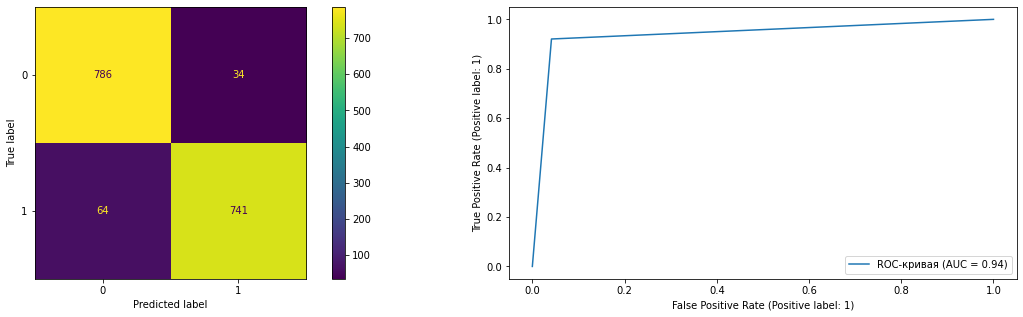

In [ ]:
logreg_best = gscv.best_estimator_
scores(logreg_best, test_X, test_y)

In [ ]:
rscv = RandomizedSearchCV(Pipeline([("logreg", LogisticRegression(nin=train_X.shape[1]))]),
                    {"logreg__epoches" : [1, 2, 4],
                     "logreg__batch_size" : [5, 10, 20],
                     "logreg__SGD_step" : [0.01, 0.05, 0.1]})
rscv.fit(train_X, train_y)
best(rscv)

Best params: {'logreg__epoches': 4, 'logreg__batch_size': 10, 'logreg__SGD_step': 0.1}
Best acc: 0.9361429501983775


Accuracy: 0.9403076923076923
Recall: 0.9217391304347826
Precision: 0.9561855670103093


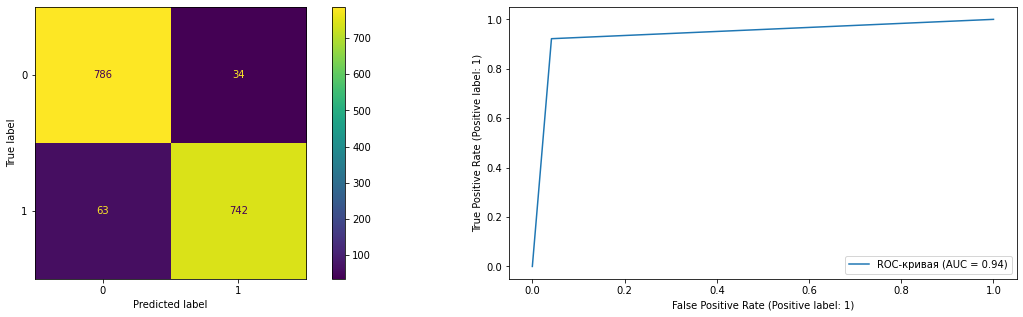

In [ ]:
logreg_best = rscv.best_estimator_
scores(logreg_best, test_X, test_y)

In [ ]:
f = open("logreg.pkl", "wb")
pickle.dump(logreg_best, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [ ]:
gscv = GridSearchCV(Pipeline([("logreg", LogisticRegression())]),
                    {"logreg__penalty" : ["l2", "none"],
                     "logreg__solver" : ["newton-cg", "lbfgs"],
                     "logreg__max_iter" : [1000, 10000]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'logreg__max_iter': 1000, 'logreg__penalty': 'none', 'logreg__solver': 'newton-cg'}
Best acc: 0.9612233078699592


Accuracy: 0.9649230769230769
Recall: 0.9565217391304348
Precision: 0.9722222222222222


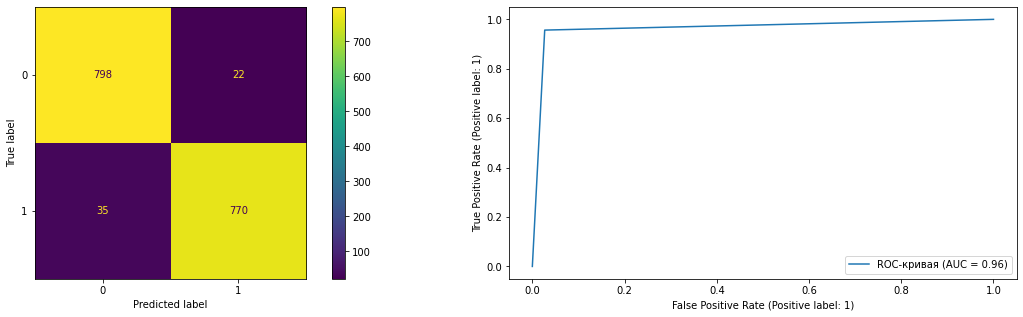

In [ ]:
logreg_best = gscv.best_estimator_
scores(logreg_best, test_X, test_y)

#SVN

In [ ]:
class SVM(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches=1, batch_size=10, SGD_step=0.001, alpha=0.1, nin=10):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.nin = nin
        self.alpha = alpha
        self.Net = SoftMarginSVM(nin, alpha)

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        return self

    def predict(self, X):
        y = self.Net.predict(X)
        return y

    def getW(self):
        return self.Net.W

In [ ]:
gscv = GridSearchCV(Pipeline([("SVM", SVM(nin=train_X.shape[1]))]),
                    {"SVM__epoches" : [1, 2, 4],
                     "SVM__batch_size" : [5, 10, 20],
                     "SVM__SGD_step" : [0.01, 0.05, 0.1],
                     "SVM__alpha" : [1.0, 0.1, 0.01, 0.0]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'SVM__SGD_step': 0.01, 'SVM__alpha': 0.0, 'SVM__batch_size': 20, 'SVM__epoches': 4}
Best acc: 0.9479901699532185


Accuracy: 0.952
Recall: 0.9453416149068323
Precision: 0.9572327044025157


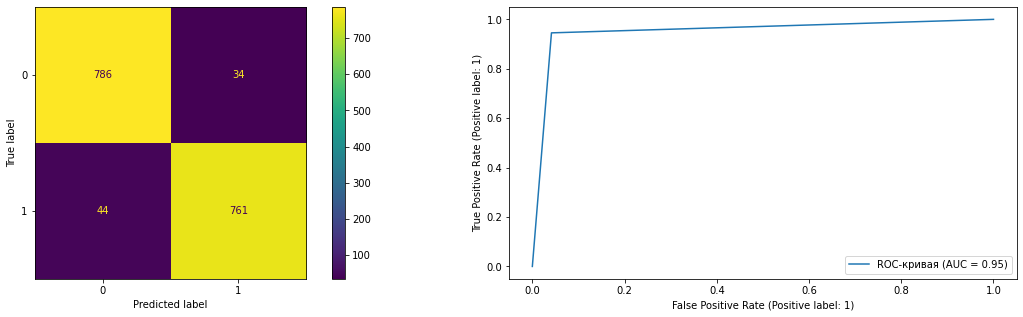

In [ ]:
SVM_best = gscv.best_estimator_
scores(SVM_best, test_X, test_y)

In [ ]:
f = open("SVM.pkl", "wb")
pickle.dump(SVM_best, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [ ]:
rscv = RandomizedSearchCV(Pipeline([("SVM", SVM(nin=train_X.shape[1]))]),
                    {"SVM__epoches" : [1, 2, 4],
                     "SVM__batch_size" : [5, 10, 20],
                     "SVM__SGD_step" : [0.01, 0.05, 0.1],
                     "SVM__alpha" : [1.0, 0.1, 0.01, 0.0]})
rscv.fit(train_X, train_y)
best(rscv)

Best params: {'SVM__epoches': 2, 'SVM__batch_size': 20, 'SVM__alpha': 1.0, 'SVM__SGD_step': 0.01}
Best acc: 0.9424526558891454


Accuracy: 0.924923076923077
Recall: 0.8906832298136645
Precision: 0.9547270306258322


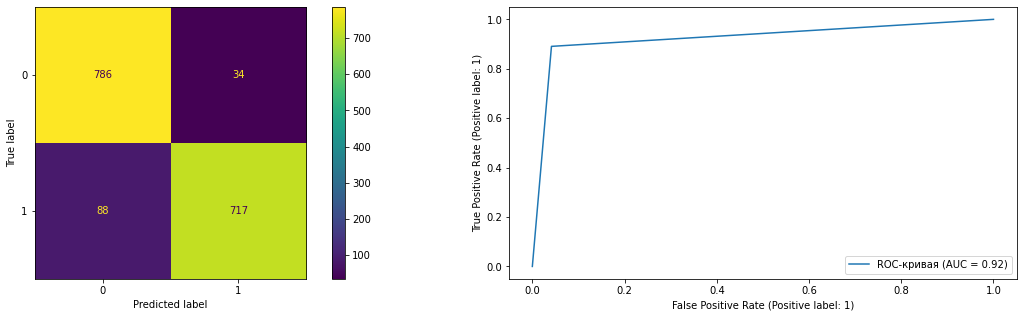

In [ ]:
SVM_best = rscv.best_estimator_
scores(SVM_best, test_X, test_y)

In [ ]:
gscv = GridSearchCV(Pipeline([("svc", LinearSVC())]),
                    {"svc__loss" : ["hinge", "squared_hinge"],
                     "svc__max_iter" : [1e5, 1e6]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'svc__loss': 'hinge', 'svc__max_iter': 100000.0}
Best acc: 0.9459899330846213


Accuracy: 0.9353846153846154
Recall: 0.9093167701863354
Precision: 0.9581151832460733


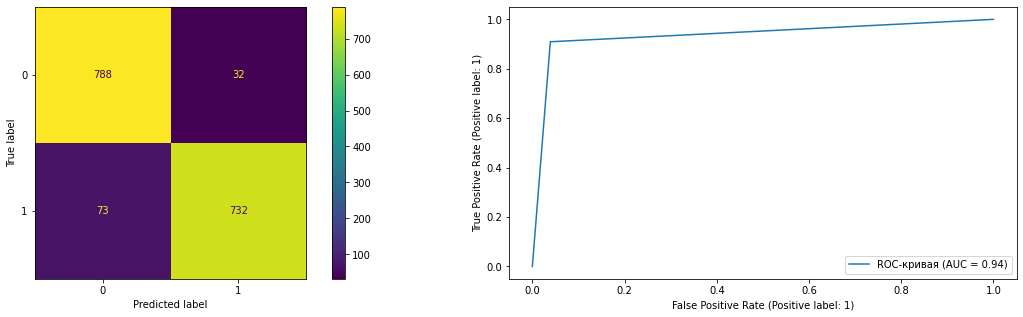

In [ ]:
SVM_best = gscv.best_estimator_
scores(SVM_best, test_X, test_y)

#KNN

In [ ]:
class kNN(BaseEstimator, ClassifierMixin):

    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self, ['X_', 'y_'])
        X = check_array(X)

        y = np.ndarray((X.shape[0],))
        for (i, elem) in enumerate(X):
            distances = euclidean_distances([elem], self.X_)[0]
            indexes = np.argsort(distances, kind='heapsort')

            indexes = indexes[:self.k]
            labels, cnts = np.unique(self.y_[indexes], return_counts=True)
            y[i] = labels[cnts.argmax()]
        return y


In [ ]:
gscv = GridSearchCV(Pipeline([('knn', kNN())]), {'knn__k' : [1, 3, 5, 7, 9]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'knn__k': 1}
Best acc: 1.0


Accuracy: 1.0
Recall: 1.0
Precision: 1.0


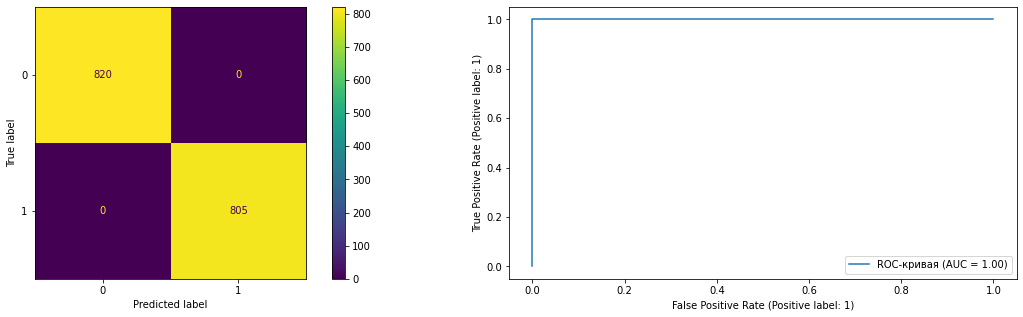

In [ ]:
knn_best = gscv.best_estimator_
scores(knn_best, test_X, test_y)

In [ ]:
f = open("kNN.pkl", "wb")
pickle.dump(gscv.best_estimator_, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [ ]:
gscv = GridSearchCV(Pipeline([('knn', KNeighborsClassifier())]), {'knn__n_neighbors' : [1, 3, 5, 7, 9]})
gscv.fit(train_X, train_y)
best(gscv)

Best params: {'knn__n_neighbors': 1}
Best acc: 1.0


Accuracy: 1.0
Recall: 1.0
Precision: 1.0


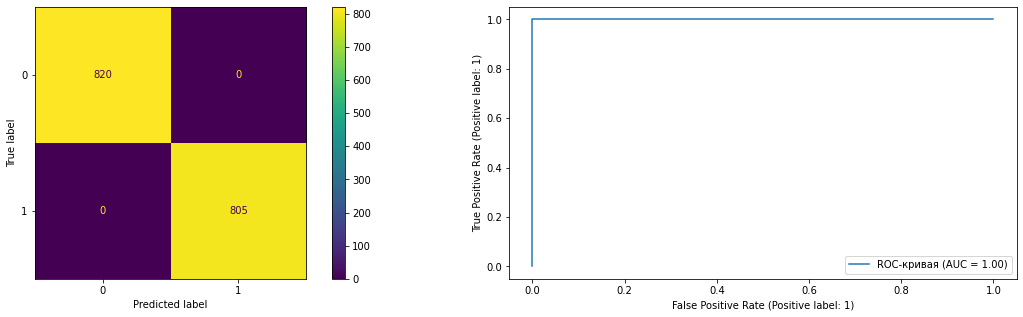

In [ ]:
knn_best = gscv.best_estimator_
scores(knn_best, test_X, test_y)

#Naive Bayes

In [ ]:
class NaiveBayes(ClassifierMixin, BaseEstimator):
    def __init__(self):
        None

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True

        labels, cnts = np.unique(self.y_, return_counts=True)
        self.labels = labels
        self.p_of_y = np.array([elem / self.y_.shape[0] for elem in cnts])
        self.means = np.array([self.X_[self.y_ == elem].mean(axis=0) for elem in labels])
        self.stds = np.array([self.X_[self.y_ == elem].std(axis=0) for elem in labels])
        return self

    def gaussian(self, mu, sigma, x0):
        return np.exp(-(x0 - mu) ** 2 / (2 * sigma)) / np.sqrt(2.0 * pi * sigma)

    def predict(self, X):
        check_is_fitted(self, ['X_', 'y_'])

        X = check_array(X)

        res = np.zeros(X.shape[0])
        for (i, elem) in enumerate(X):
            p = np.array(self.p_of_y)
            for (j, label) in enumerate(self.labels):
                p_x_cond_y = np.array(
                    [self.gaussian(self.means[j][k], self.stds[j][k], elem[k]) for k in range(X.shape[1])])
                p[j] *= np.prod(p_x_cond_y)
            res[i] = np.argmax(p)
        return res

Accuracy: 0.8116923076923077
Recall: 0.9664596273291925
Precision: 0.7360454115421002


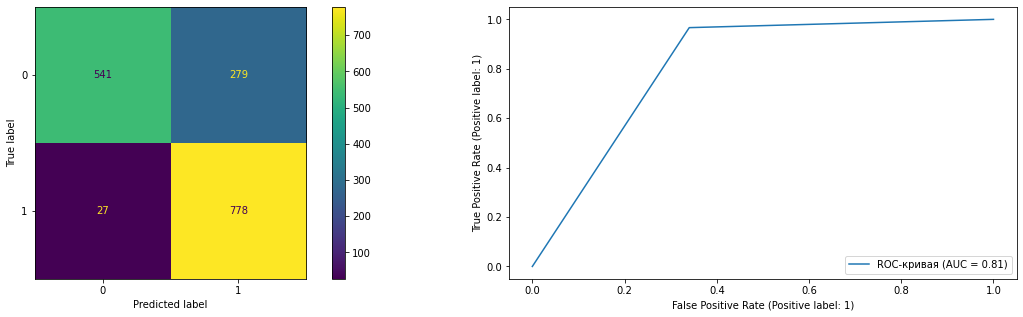

In [ ]:
NB = Pipeline([("NB", NaiveBayes())])
NB.fit(train_X, train_y)
scores(NB, test_X, test_y)

In [ ]:
f = open("NB.pkl", "wb")
pickle.dump(NB, f, pickle.HIGHEST_PROTOCOL)
f.close()

Accuracy: 0.9163076923076923
Recall: 0.9142857142857143
Precision: 0.9165628891656289


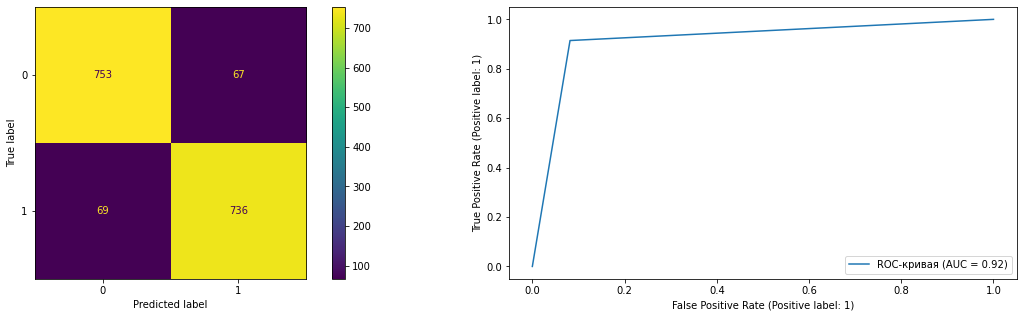

In [ ]:
NB = Pipeline([("NB", GaussianNB())])
NB.fit(train_X, train_y)
scores(NB, test_X, test_y)